Code used to rerun analysis using updated data from resynthesized polymers
Adds feature analysis

In [1]:
#import block

#imports
import numpy as np
import matplotlib.pyplot as plt
import shutil
import sys
import os.path
import json
import seaborn as sns
import pandas as pd
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AtomPairs import Pairs
from rdkit.Chem.rdFingerprintGenerator import GetRDKitFPGenerator
import ot
import csv
from pickle import dump
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import pairwise_distances
from scipy.optimize import minimize
from scipy.stats import bernoulli
from scipy.special import expit as sigmoid
from sklearn.datasets import make_moons
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, RationalQuadratic
from multiprocessing import Pool

#import EMD calculation from Jiale's project
from Polymer_Similarity import EMD_Calculation_pot as EMD

In [60]:
# function definition block
def str_to_list(string):
    #string='"'+str(string)+'"'
    counter=string.count(',')
    #print(counter)
    list=[]
    for i in range(counter):
        if counter ==1:
            string=string[1:len(string)-1]
        if i==0 and counter>1:
            j=string.index(',')
            list+=[string[2:j-1]]
            string=string[j+1:len(string)-1]
            if string[0]==' ':
                string=string[1:]
        elif i==counter-1:
            j=string.index(',')
            list+=[string[1:j-1]]
            if string[j+1]==' ':
                list+=[string[j+3:len(string)-1]]
            else:
                list+=[string[j+2:len(string)-1]]
        else:
            j=string.index(',')
            list+=[string[1:j-1]]
            if string[0]==' ':
                string=string[j+2:]
            else:
                string=string[j+1:]
        #print(string)

    return list

def concatenate_indices(indices,leave_out):
    #indices is a list of the split arrays, leave out is the index number of the test set
    newlist=[]
    test=None
    for i in range(len(indices)):
        if i==leave_out:
            test=indices[i]
        else:
            newlist+=[indices[i]]
    train=newlist[0]
    for i in range(1,len(newlist)):
        train=np.concatenate((train,newlist[i]),0)
    return [train,test]

def rf_cross_val(C, xs, ys,testx,testy,name):
    #C should be [n_estimators, max_depth,max_leaf_nnodes]
    #xs and ys give a list of the different dataset splices - must be same length, indices in each must match
        #this should be the full training set (will iterate which set is being used as the validation set for cross validation
    #added in option for testx and test y to be list of tests rather than just one test
    scores = []
    for i in range(0, len(xs)):
        X = concatenate_indices(xs, i)
        Y = concatenate_indices(ys, i)
        model = RandomForestClassifier(n_estimators=C[0], max_depth=C[1], min_samples_split=2, min_samples_leaf=1,max_leaf_nodes=C[2],random_state=42)
        model.fit(X[0], Y[0])
        scores += [model.score(X[1], Y[1])]
    score_array = np.array(scores)
    mean = np.mean(score_array)
    std = np.std(score_array)

    #now evaluate against unseen testing data
    X = concatenate_indices(xs, None)
    Y = concatenate_indices(ys, None)
    model = RandomForestClassifier(n_estimators=C[0], max_depth=C[1], min_samples_split=2, min_samples_leaf=1,max_leaf_nodes=C[2],random_state=42)
    model.fit(X[0], Y[0])
    if isinstance(testx,list):
        eval=[]
        for i in range(len(testx)):
            eval+=[model.score(testx[i],testy[i])]
    else:
        eval=model.score(testx,testy)
    with open("./Updated_Modeling_Rev/"+str(name)+"RF_[n_estim,max_depth,max_leaf]_"+str(C)+".pkl", "wb") as f:
        dump(model, f, protocol=5)
    return [mean, std, eval]

def train_rf(C,xs,ys,name):
    #C should be [n_estimators, max_depth,max_leaf_nnodes]
    #xs and ys should be list of the training data (no validation set, test set should be left out)
    # X = concatenate_indices(xs, None)
    # Y = concatenate_indices(ys, None)
    X=xs
    print('X',np.shape(X))
    # print('Y',np.shape(Y))
    Y=ys
    print('Y',np.shape(Y))
    model = RandomForestClassifier(n_estimators=C[0], max_depth=C[1], min_samples_split=2, min_samples_leaf=1, max_leaf_nodes=C[2],random_state=42)
    model.fit(X, Y)
    with open("./Updated_Modeling_Rev/"+str(name)+"_RF_[n_estim,max_depth,max_leaf]_"+str(C)+".pkl", "wb") as f:
        dump(model, f, protocol=5)
    return model

def update_rf(old_model,C,xs,ys):
    #this takes an existing trained rf and fits additional trees given additional training data
    #C should be the number of additional estimators (trees) to fit
    #xs and ys should be list of the training data (no validation set, test set should be left out)
    n_estims=len(old_model.estimators_)

    X = concatenate_indices(xs, None)
    Y = concatenate_indices(ys, None)
    model_list=[]
    estimator_amounts=[]
    model = old_model.set_params(n_estimators=C+n_estims,warm_start=True)
    model.fit(X[0], Y[0])
    return model


def lin_cross_val(C, xs, ys,xtest,ytest,name):
    #C should be [loss, alpha]
    #xs and ys give a list of the different dataset splices - must be same length, indices in each must match
        #this should be the full training set (will iterate which set is being used as the validation set for cross validation
    scores = []
    for i in range(0, len(xs)):
        X = concatenate_indices(xs, i)
        Y = concatenate_indices(ys, i)
        model =SGDClassifier(loss=C[0], alpha=C[1],shuffle=True)
        model.fit(X[0], Y[0])
        scores += [model.score(X[1], Y[1])]
    score_array = np.array(scores)
    mean = np.mean(score_array)
    std = np.std(score_array)
    X = concatenate_indices(xs, None)
    Y = concatenate_indices(ys, None)
    model = SGDClassifier(loss=C[0], alpha=C[1], shuffle=True)
    model.fit(X[0],Y[0])
    eval=model.score(xtest,ytest)
    #save the model
    with open("./240527_with_Terpolymers_Optimization Models/SGD_"+str(name)+"_[loss,alpha]_"+str(C)+".pkl", "wb") as f:
        dump(model, f, protocol=5)
    return [mean, std,eval]

def train_lin(C, xs,ys,name):
    X=xs
    print('X',np.shape(X))
    # print('Y',np.shape(Y))
    Y=ys
    print('Y',np.shape(Y))
    model = SGDClassifier(loss=C[0], alpha=C[1], shuffle=True,random_state=42)
    model.fit(X, Y)
    with open("./Updated_Modeling_Rev/"+str(name)+"SDG_"+str(name)+"[loss,alpha]"+str(C)+".pkl", "wb") as f:
        dump(model, f, protocol=5)
    return model

def update_lin(old_model, xs, ys):
    #xs are additional new data that needs to be fit
    #ys are labels corresponding to xs
    class_biodeg=[0,1] #pretty sure since we use 0 or 1 this is all we've got
    model=old_model.partial_fit(xs,ys,classes=class_biodeg)
    return model

def get_EMD_array(sets,basis,EMD_values=["RDKFingerprint","Tanimoto",5,512]):
    #sets = list of sets (pd dataframes) that need EMD calculations against the basis
    #if basis=None then the concatenation of the sets is used as basis. If not, give polymer basis
    #EMD_values gives [embedding_function, similarity_score_function, radius, num_bits]

    EMD_arrays=[]
    for k in range(len(sets)):
        col = []
        for i in range(len(sets[k].index)):
            row = []
            for j in range(len(basis.index)):
                X = sets[k]['SMILES_List'][i]
                #print(X)
                if isinstance(X,str):
                    X = str_to_list(X)
                #print(X)
                Y = sets[k]['Ratio_List'][i]
                #print(basis['SMILES_List'])
                #print("basis",basis['SMILES_List'][j])
                Z = basis['SMILES_List'][j]
                #print(Z)
                if isinstance(Z,str):
                    Z = str_to_list(Z)
                #print(Z)
                W = basis['Ratio_List'][j]
                # W=str_to_list(W)
                #print(X, Y, Z, W)
                score = EMD(
                    query_smiles_list=X,
                    query_smiles_weight_list=Y,
                    target_smiles_list=Z,
                    target_smiles_weight_list=W,
                    embedding_function=EMD_values[0],
                    similarity_score_function=EMD_values[1],
                    radius=EMD_values[2],
                    num_bits=EMD_values[3],
                )
                row += [score]
            col += [row]
        # save the list of lists as a npy array
        formed = np.array(col)
        EMD_arrays+=[formed]
    return EMD_arrays


In [13]:
#make a set of identical splits (which polymers are in which split) with updated details.
ter_Julia_r=pd.read_csv('./Library_Data_Julia_Consolidated_Revision.csv',sep='\t',header=0)
# print(ter_Julia_r)
ter_other_r=pd.read_csv('./Library_Data_Consolidated_Revision.csv',header=0)
# print(ter_other_r)
ter_Julia=ter_Julia_r[['Polymer_Name_P','Biodegradable','Ratio 1','Ratio 2','Ratio 3']]
ter_other=ter_other_r[['Polymer_Name_P','Biodegradable','Ratio 1','Ratio 2','Ratio 3']]
ter_all=pd.concat([ter_Julia,ter_other])
print(ter_all)
for i in range(6):
    all=pd.read_csv('./Terpolymer_Splits/split_'+str(i)+'.csv',header=0)
    set_A=pd.read_csv('./Terpolymer_Splits/split_'+str(i)+'_A'+'.csv',header=0)
    set_B=pd.read_csv('./Terpolymer_Splits/split_'+str(i)+'_B'+'.csv',header=0)
    new_all=ter_all[ter_all['Polymer_Name_P'].isin(all['Polymer_Name_P'])]
    new_setA=ter_all[ter_all['Polymer_Name_P'].isin(set_A['Polymer_Name_P'])]
    new_setB=ter_all[ter_all['Polymer_Name_P'].isin(set_B['Polymer_Name_P'])]
    new_all.to_csv(path_or_buf='./Terpolymer_Splits_Rev/split_'+str(i)+'.csv')
    new_setA.to_csv(path_or_buf='./Terpolymer_Splits_Rev/split_'+str(i)+'_A'+'.csv')
    new_setB.to_csv(path_or_buf='./Terpolymer_Splits_Rev/split_'+str(i)+'_B'+'.csv')

          Polymer_Name_P Biodegradable  Ratio 1  Ratio 2  Ratio 3
0    ADA25_DMI25_BND50_P             Y      1.4      0.6      2.0
1    ADA25_DMI25_BTD50_P             Y      0.9      1.1      2.0
2    ADA25_DMT25_BPA50_P             N      1.8      0.2      2.0
3    ADA25_DMT25_DPD50_P             N      1.1      0.9      2.0
4    ADA25_DMT25_HND50_P             Y      1.2      0.8      2.0
..                   ...           ...      ...      ...      ...
230  DGA25_CCD25_GGE50_P             Y      1.0      1.0      2.0
231  EBA25_AZA25_BPA50_P             Y      0.9      1.1      2.0
232  GLA25_SBA25_BPA50_P             Y      1.1      0.9      2.0
233  EBA25_SBA25_BPA50_P             Y      0.9      1.1      2.0
234  GLA25_SUA25_BPA50_P             N      1.7      0.3      2.0

[300 rows x 5 columns]


In [14]:
#write npy file of the ys for each of the ys for each set

for i in range(6):
    all=pd.read_csv('./Terpolymer_Splits_Rev/split_'+str(i)+'.csv',header=0)
    set_A=pd.read_csv('./Terpolymer_Splits_Rev/split_'+str(i)+'_A'+'.csv',header=0)
    set_B=pd.read_csv('./Terpolymer_Splits_Rev/split_'+str(i)+'_B'+'.csv',header=0)
    all_biodeg=all['Biodegradable'].replace('N',0)
    all_biodeg=all_biodeg.replace('Y',1)
    set_A_biodeg=set_A['Biodegradable'].replace('N',0)
    set_A_biodeg=set_A_biodeg.replace('Y',1)
    set_B_biodeg=set_B['Biodegradable'].replace('Y',1)
    set_B_biodeg=set_B_biodeg.replace('N',0)
    all_biodeg_np=all_biodeg.to_numpy()
    set_A_biodeg_np=set_A_biodeg.to_numpy()
    set_B_biodeg_np=set_B_biodeg.to_numpy()
    print(set_A_biodeg_np)
    np.save('./Terpolymer_Splits_Rev/split'+str(i)+'_ys',all_biodeg_np,allow_pickle=False)
    np.save('./Terpolymer_Splits_Rev/split'+str(i)+'_A_ys',set_A_biodeg_np,allow_pickle=False)
    np.save('./Terpolymer_Splits_Rev/split'+str(i)+'_B_ys',set_B_biodeg_np,allow_pickle=False)

[0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]


/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_7557/3403175859.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_biodeg=all_biodeg.replace('Y',1)
/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_7557/3403175859.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  set_A_biodeg=set_A_biodeg.replace('Y',1)
/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_7557/3403175859.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old

In [15]:
def get_smiles_and_ratios_list(dataframe):
    names=dataframe['Polymer_Name_P'].to_list()
    ratio1=dataframe['Ratio 1'].to_list()
    ratio2=dataframe['Ratio 2'].to_list()
    ratio3=dataframe['Ratio 3'].to_list()
    smiles=[]
    ratios=[]
    monomers=pd.read_csv('./Monomer Info_DMTDMI.csv',header=0)
    for i in range(len(names)):
        name=names[i]
        smile=[]
        smile+=[str(monomers.loc[monomers['Polymer Name Abbr.']==name[0:3],'SMILES_Monomers'].item())]
        smile+=[str(monomers.loc[monomers['Polymer Name Abbr.']==name[6:9],'SMILES_Monomers'].item())]
        smile+=[str(monomers.loc[monomers['Polymer Name Abbr.']==name[12:15],'SMILES_Monomers'].item())]
        #print(smile)
        smiles+=[smile]
        #print(smiles)
        ratios+=[[ratio1[i]/2,ratio2[i]/2,ratio3[i]/2]]
    return[smiles,ratios]

In [16]:
#load the models that were trained on the original library and reduced library
#original_rf selected for cross_val>0.7 and test score >0.72
original_rf=[[8,4,8],[16,16,128],[16,128,512],[32,256,8]]
#reduced_rf selected for cross_val>0.81
reduced_rf=[[8,2,8],[16,4,128],[64,256,8],[256,4,256]]
#original_SDG selected for
original_SDG=[['hinge',0.1],['log_loss',0.01],['perceptron',0.001]]
#reduced SDG selected for
reduced_SDG=[['hinge',0.1],['log_loss',0.1],['perceptron',0.0001]]
with open('optimal_model_evaluations.csv', 'w', newline='') as file:
        file_writer=csv.writer(file, delimiter=',')
        file_writer.writerow(['Dataset and Model Type','Model Parameters','Score against Terpolymer test set'])
#make EMD matrix of ter polymer test set (set 5) against original training set and reduced training set
ter_test=pd.read_csv('./Terpolymer_Splits_Rev/split_5.csv',header=0)
test_ter_list=get_smiles_and_ratios_list(ter_test)

In [17]:
def get_EMD_array_lists(sets,ratios,basis,EMD_values=["RDKFingerprint","Tanimoto",5,512]):
    #sets = list of sets (each set is a list of smiles lists dataframes) that need EMD calculations against the basis
    #ratios is a list of ratio lists corresponding to the sets
    #if basis=None then the concatenation of the sets is used as basis. If not, give polymer basis
    #EMD_values gives [embedding_function, similarity_score_function, radius, num_bits]

    EMD_arrays=[]
    for k in range(len(sets)):
        col = []
        for i in range(len(sets[k])):
            row = []
            for j in range(len(basis.index)):
                X = sets[k][i]
                print(X)
                Y = ratios[k][i]
                #print(basis['SMILES_List'])
                #print("basis",basis['SMILES_List'][j])
                Z = basis['SMILES_List'][j]
                #print(Z)
                Z = str_to_list(Z)
                W = basis['Ratio_List'][j]
                # W=str_to_list(W)
                #print(X, Y, Z, W)
                score = EMD(
                    query_smiles_list=X,
                    query_smiles_weight_list=Y,
                    target_smiles_list=Z,
                    target_smiles_weight_list=W,
                    embedding_function=EMD_values[0],
                    similarity_score_function=EMD_values[1],
                    radius=EMD_values[2],
                    num_bits=EMD_values[3],
                )
                row += [score]
            col += [row]
        # save the list of lists as a npy array
        formed = np.array(col)
        EMD_arrays+=[formed]
    return EMD_arrays

In [18]:
#load original and reduced data
os0=pd.read_csv('./ML_splits/original_split0.csv',header=0)
os1=pd.read_csv('./ML_splits/original_split1.csv',header=0)
os2=pd.read_csv('./ML_splits/original_split2.csv',header=0)
os3=pd.read_csv('./ML_splits/original_split3.csv',header=0)
os4=pd.read_csv('./ML_splits/original_split4.csv',header=0)
os5=pd.read_csv('./ML_splits/original_split5.csv',header=0)
y_set0=np.load('./ML_splits/Biodeg_fororiginal_split0_vsfull_library.npy')
y_set1=np.load('./ML_splits/Biodeg_fororiginal_split1_vsfull_library.npy')
y_set2=np.load('./ML_splits/Biodeg_fororiginal_split2_vsfull_library.npy')
y_set3=np.load('./ML_splits/Biodeg_fororiginal_split3_vsfull_library.npy')
y_set4=np.load('./ML_splits/Biodeg_fororiginal_split4_vsfull_library.npy')
y_set5=np.load('./ML_splits/Biodeg_fororiginal_split5_vsfull_library.npy')
os_train=[os0,os1,os2,os3,os4] #the training data for the cross validation/full model
os_train_pd=pd.concat(os_train).reset_index()
rl0=pd.read_csv('./Reduced_ML_Splits/reduced_split0.csv',header=0)
rl1=pd.read_csv('./Reduced_ML_Splits/reduced_split1.csv',header=0)
rl2=pd.read_csv('./Reduced_ML_Splits/reduced_split2.csv',header=0)
rl3=pd.read_csv('./Reduced_ML_Splits/reduced_split3.csv',header=0)
rl4=pd.read_csv('./Reduced_ML_Splits/reduced_split4.csv',header=0)
rl5=pd.read_csv('./Reduced_ML_Splits/reduced_split5.csv',header=0)
rl_train=[rl0,rl1,rl2,rl3,rl4] #the training data used for cross validation/full model
rl_train_pd=pd.concat(rl_train).reset_index()

In [21]:
#get the EMD arrays for terpolymer testing vs original and reduced libraries
tertest_emd_vs_orig=get_EMD_array_lists([test_ter_list[0]],[test_ter_list[1]],os_train_pd)
tertest_emd_vs_reduc=get_EMD_array_lists([test_ter_list[0]],[test_ter_list[1]],rl_train_pd)
np.save('./Terpolymer_Splits_Rev/EMD_split'+str(5)+'_vs_orig',tertest_emd_vs_orig,allow_pickle=False)
np.save('./Terpolymer_Splits_Rev/EMD_split'+str(5)+'_vs_reduc',tertest_emd_vs_reduc,allow_pickle=False)

['C(=O)CCCCC(=O)', 'C(=O)c(ccc1)cc1C(=O)', 'OCCCCO']
['C(=O)CCCCC(=O)', 'C(=O)c(ccc1)cc1C(=O)', 'OCCCCO']
['C(=O)CCCCC(=O)', 'C(=O)c(ccc1)cc1C(=O)', 'OCCCCO']
['C(=O)CCCCC(=O)', 'C(=O)c(ccc1)cc1C(=O)', 'OCCCCO']
['C(=O)CCCCC(=O)', 'C(=O)c(ccc1)cc1C(=O)', 'OCCCCO']
['C(=O)CCCCC(=O)', 'C(=O)c(ccc1)cc1C(=O)', 'OCCCCO']
['C(=O)CCCCC(=O)', 'C(=O)c(ccc1)cc1C(=O)', 'OCCCCO']
['C(=O)CCCCC(=O)', 'C(=O)c(ccc1)cc1C(=O)', 'OCCCCO']
['C(=O)CCCCC(=O)', 'C(=O)c(ccc1)cc1C(=O)', 'OCCCCO']
['C(=O)CCCCC(=O)', 'C(=O)c(ccc1)cc1C(=O)', 'OCCCCO']
['C(=O)CCCCC(=O)', 'C(=O)c(ccc1)cc1C(=O)', 'OCCCCO']
['C(=O)CCCCC(=O)', 'C(=O)c(ccc1)cc1C(=O)', 'OCCCCO']
['C(=O)CCCCC(=O)', 'C(=O)c(ccc1)cc1C(=O)', 'OCCCCO']
['C(=O)CCCCC(=O)', 'C(=O)c(ccc1)cc1C(=O)', 'OCCCCO']
['C(=O)CCCCC(=O)', 'C(=O)c(ccc1)cc1C(=O)', 'OCCCCO']
['C(=O)CCCCC(=O)', 'C(=O)c(ccc1)cc1C(=O)', 'OCCCCO']
['C(=O)CCCCC(=O)', 'C(=O)c(ccc1)cc1C(=O)', 'OCCCCO']
['C(=O)CCCCC(=O)', 'C(=O)c(ccc1)cc1C(=O)', 'OCCCCO']
['C(=O)CCCCC(=O)', 'C(=O)c(ccc1)cc1C(=O)', 'OC

In [22]:
#load all the models of interest to test against and record performance vs ter_polymer test set
import pickle
Xval=np.load('./Terpolymer_Splits_Rev/EMD_split5_vs_orig.npy')[0]
print(Xval)
Yval=np.load('./Terpolymer_Splits_Rev/split5_ys.npy')
for i in range(len(original_rf)):
    C=original_rf[i]
    with open("./240523_Optimization_Models/RF_os_estim_"+str(C[0])+"_depth_"+str(C[1])+"_leafnodes_"+str(C[2])+".pkl", "rb") as f:
        model=pickle.load(f)
    value=model.score(Xval,Yval)
    with open('optimal_model_evaluations.csv', 'a', newline='') as file:
        file_writer=csv.writer(file, delimiter=',')
        file_writer.writerow(['RF_Original',str(C),value])
Xval_r=np.load('./Terpolymer_Splits/EMD_split5_vs_reduc.npy')[0]

for i in range(len(reduced_rf)):
    C=reduced_rf[i]
    with open("./240523_Optimization_Models/RF_rl_estim_"+str(C[0])+"_depth_"+str(C[1])+"_leafnodes_"+str(C[2])+".pkl", "rb") as f:
        model=pickle.load(f)
    value=model.score(Xval_r,Yval)
    with open('optimal_model_evaluations.csv', 'a', newline='') as file:
        file_writer=csv.writer(file, delimiter=',')
        file_writer.writerow(['RF_Reduced',str(C),value])

[[0.59524941 0.77343941 0.82879538 ... 0.69088866 0.76772023 0.89995954]
 [0.63368785 0.76847492 0.82745498 ... 0.70016118 0.79549801 0.8924069 ]
 [0.53244811 0.39765681 0.63422192 ... 0.73460971 0.84112554 0.88124281]
 ...
 [0.58732832 0.84633029 0.82900009 ... 0.60527702 0.70297068 0.72024521]
 [0.5734815  0.9322952  0.87475113 ... 0.52927195 0.67087087 0.74775696]
 [0.78942815 0.92710521 0.81596155 ... 0.61946073 0.63408202 0.75195574]]


In [23]:
#original_SDG selected for
original_SDG=[['hinge',0.1],['log_loss',0.01],['perceptron',0.001]]
#reduced SDG selected for
reduced_SDG=[['hinge',0.1],['log_loss',0.1],['perceptron',0.0001]]
for i in range(len(original_SDG)):
    C=original_SDG[i]
    with open("./240523_Optimization_Models/SGD_os"+"_loss_"+str(C[0])+"_alpha_"+str(C[1])+".pkl", "rb") as f:
        model=pickle.load(f)
    value=model.score(Xval,Yval)
    with open('optimal_model_evaluations.csv', 'a', newline='') as file:
        file_writer=csv.writer(file, delimiter=',')
        file_writer.writerow(['SDG_Original',str(C),value])
Xval_r=np.load('./Terpolymer_Splits/EMD_split5_vs_reduc.npy')[0]

for i in range(len(reduced_SDG)):
    C=reduced_SDG[i]
    with open("./240523_Optimization_Models/SGD_rl"+"_loss_"+str(C[0])+"_alpha_"+str(C[1])+".pkl", "rb") as f:
        model=pickle.load(f)
    value=model.score(Xval_r,Yval)
    with open('optimal_model_evaluations.csv', 'a', newline='') as file:
        file_writer=csv.writer(file, delimiter=',')
        file_writer.writerow(['SDG_Reduced',str(C),value])

In [24]:
#generate all the possible EMD 'landscapes' that we may be interested in from the ter polymer splits + the original library and reduced library#load original and reduced data
os0=pd.read_csv('./ML_splits/original_split0.csv',header=0)
os1=pd.read_csv('./ML_splits/original_split1.csv',header=0)
os2=pd.read_csv('./ML_splits/original_split2.csv',header=0)
os3=pd.read_csv('./ML_splits/original_split3.csv',header=0)
os4=pd.read_csv('./ML_splits/original_split4.csv',header=0)
os5=pd.read_csv('./ML_splits/original_split5.csv',header=0)
y_set0=np.load('./ML_splits/Biodeg_fororiginal_split0_vsfull_library.npy')
y_set1=np.load('./ML_splits/Biodeg_fororiginal_split1_vsfull_library.npy')
y_set2=np.load('./ML_splits/Biodeg_fororiginal_split2_vsfull_library.npy')
y_set3=np.load('./ML_splits/Biodeg_fororiginal_split3_vsfull_library.npy')
y_set4=np.load('./ML_splits/Biodeg_fororiginal_split4_vsfull_library.npy')
y_set5=np.load('./ML_splits/Biodeg_fororiginal_split5_vsfull_library.npy')
os_train=[os0,os1,os2,os3,os4,os5] #the training data for the cross validation/full model

rl0=pd.read_csv('./Reduced_ML_Splits/reduced_split0.csv',header=0)
rl1=pd.read_csv('./Reduced_ML_Splits/reduced_split1.csv',header=0)
rl2=pd.read_csv('./Reduced_ML_Splits/reduced_split2.csv',header=0)
rl3=pd.read_csv('./Reduced_ML_Splits/reduced_split3.csv',header=0)
rl4=pd.read_csv('./Reduced_ML_Splits/reduced_split4.csv',header=0)
rl5=pd.read_csv('./Reduced_ML_Splits/reduced_split5.csv',header=0)
rl_train=[rl0,rl1,rl2,rl3,rl4,rl5] #the training data used for cross validation/full model
# print(rl_train)

os_train_xs=[]
os_train_ys=[]
for dataframe in os_train:
    os_train_xs+=[dataframe[['SMILES_List','Ratio_List']]]
    os_train_ys+=[dataframe['Biodegradability'].to_numpy()]
rl_train_xs=[]
rl_train_ys=[]
for dataframe in rl_train:
    rl_train_xs+=[dataframe[['SMILES_List','Ratio_List']]]
    rl_train_ys+=[dataframe['Biodegradability'].to_numpy()]
#different landscape sets to look at
original_only_incr=[] #list of the pd dataframes with only original library members as landscape
reduced_only_incr=[] #list of the pd dataframes with only reduced library members as landscape
original_ter_incr=[] #list of pd dataframes with original and terpolymers as landscape in increasing amounts
reduced_ter_incr=[] #list of pd dataframes with reduced and terpolymers as landscape in increasing amounts

#list of np arrays that correspond to list of pd dataframes for training the models
original_only_ys=[]
reduced_only_ys=[]
original_ter_ys=[]
reduced_ter_ys=[]

original_only=os_train_xs[0]
reduced_only=rl_train_xs[0]
original_total=os_train_xs[0]
reduced_total=rl_train_xs[0]
original_only_y=os_train_ys[0]
reduced_only_y=rl_train_ys[0]
original_ter_y=os_train_ys[0]
reduced_ter_y=rl_train_ys[0]
# print(np.size(reduced_ter_y))
for i in range(5):
    #print(i)
    A_pd=pd.read_csv('./Terpolymer_Splits_Rev/split_'+str(i)+'_A.csv',header=0)
    B_pd=pd.read_csv('./Terpolymer_Splits_Rev/split_'+str(i)+'_B.csv',header=0)
    A_np=np.load('./Terpolymer_Splits_Rev/split'+str(i)+'_A_ys.npy')
    B_np=np.load('./Terpolymer_Splits_Rev/split'+str(i)+'_B_ys.npy')
    values_A=get_smiles_and_ratios_list(A_pd)
    #print(values_A[0])
    values_B=get_smiles_and_ratios_list(B_pd)
    #print(values_B)
    A_newpd=pd.DataFrame({'SMILES_List':values_A[0],'Ratio_List':values_A[1]})
    #print(A_newpd)
    B_newpd=pd.DataFrame({'SMILES_List':values_B[0],'Ratio_List':values_B[1]})
    #print(original_total)
    if i ==0:
        original_total=pd.concat((os_train_xs[i],A_newpd,B_newpd)).reset_index(drop=True)
        #print(original_total)
        reduced_total=pd.concat([rl_train_xs[i],A_newpd,B_newpd]).reset_index(drop=True)
        original_ter_y=np.concatenate([os_train_ys[i],A_np,B_np])
        reduced_ter_y=np.concatenate([rl_train_ys[i],A_np,B_np])
        # print(np.size(reduced_ter_y))
        print('original', str(i),np.size(original_ter_y))
        print('reduced', str(i),np.size(reduced_ter_y))
    else:
        original_only=pd.concat([original_only,os_train_xs[i]]).reset_index(drop=True)
        original_total=pd.concat((original_total,os_train_xs[i],A_newpd,B_newpd)).reset_index(drop=True)
        original_only_y=np.concatenate([original_only_y,os_train_ys[i]])
        original_ter_y=np.concatenate([original_ter_y,os_train_ys[i],A_np,B_np])

        reduced_only=pd.concat([reduced_only,rl_train_xs[i]]).reset_index(drop=True)
        reduced_total=pd.concat([reduced_total,rl_train_xs[i],A_newpd,B_newpd]).reset_index(drop=True)
        reduced_only_y=np.concatenate([reduced_only_y,rl_train_ys[i]])
        reduced_ter_y=np.concatenate([reduced_ter_y,rl_train_ys[i],A_np,B_np])
        # print(np.size(reduced_ter_y))
        print('original', str(i),np.size(original_ter_y))
        print('reduced', str(i),np.size(reduced_ter_y))
    original_only_incr+=[original_only]
    original_only_ys+=[original_only_y]
    original_ter_incr+=[original_total]
    original_ter_ys+=[original_ter_y]
    reduced_only_incr+=[reduced_only]
    reduced_only_ys+=[reduced_only_y]
    reduced_ter_incr+=[reduced_total]
    reduced_ter_ys+=[reduced_ter_y]
# print(np.size(reduced_ter_ys[-1]))

with open('./Updated_Modeling_Rev/original_only_incr_landscape.pkl',"wb") as f:
    dump(original_only_incr,f,protocol=5)
with open('./Updated_Modeling_Rev/original_only_incr_landscape_ys.pkl',"wb") as f:
    dump(original_only_ys,f,protocol=5)
with open('./Updated_Modeling_Rev/original_ter_incr_landscape.pkl',"wb") as f:
    dump(original_ter_incr,f,protocol=5)
with open('./Updated_Modeling_Rev/original_ter_incr_landscape_ys.pkl',"wb") as f:
    dump(original_ter_ys,f,protocol=5)

with open('./Updated_Modeling_Rev/reduced_only_incr_landscape.pkl',"wb") as f:
    dump(reduced_only_incr,f,protocol=5)
with open('./Updated_Modeling_Rev/reduced_only_incr_landscape_ys.pkl',"wb") as f:
    dump(reduced_only_ys,f,protocol=5)
with open('./Updated_Modeling_Rev/reduced_ter_incr_landscape.pkl',"wb") as f:
    dump(reduced_ter_incr,f,protocol=5)
with open('./Updated_Modeling_Rev/reduced_ter_incr_landscape_ys.pkl',"wb") as f:
    dump(reduced_ter_ys,f,protocol=5)

original 0 157
reduced 0 87
original 1 315
reduced 1 175
original 2 474
reduced 2 265
original 3 638
reduced 3 359
original 4 809
reduced 4 460


In [26]:
#dataframe os5 is the original library test
#dataframe rl5 is the reduced library test

#make the 3 different test set evaluations
original_tests=os5[['SMILES_List','Ratio_List']]
original_tests_ys_np=os5['Biodegradability'].to_numpy()
reduced_tests=rl5[['SMILES_List','Ratio_List']]
reduced_tests_ys_np=rl5['Biodegradability'].to_numpy()

ter_test_pd=pd.DataFrame({'SMILES_List':test_ter_list[0],'Ratio_List':test_ter_list[1]})
Yval=np.load('./Terpolymer_Splits_Rev/split5_ys.npy')

original_test_pds=[original_tests,ter_test_pd,pd.concat([original_tests,ter_test_pd]).reset_index(drop=True)]
original_test_ylist=[original_tests_ys_np,Yval,np.concatenate([original_tests_ys_np,Yval])]
reduced_test_pds=[reduced_tests,ter_test_pd,pd.concat([reduced_tests,ter_test_pd]).reset_index(drop=True)]
reduced_test_ylist=[reduced_tests_ys_np,Yval,np.concatenate([reduced_tests_ys_np,Yval])]

orig_train=original_ter_incr[-1]
Y_orig_train=original_ter_ys[-1]
reduced_train=reduced_ter_incr[-1]
Y_red_train=reduced_ter_ys[-1]

In [27]:
#get the training and test X arrays (we got the y arrays above)
#the dataset we want to use is either all the training data from the original with the terpolymers or from the reduced with all the terpolymers
orig_train=original_ter_incr[-1]
Y_orig_train=original_ter_ys[-1]
reduced_train=reduced_ter_incr[-1]
Y_red_train=reduced_ter_ys[-1]
#Now calculate the EMD matrices for our 4 landscape sets
#no terpolymer info in landscapes, original library
original_only_emd_train=[] #this should end up being a list of training arrays
original_only_emd_test=[] #this ends up being a list of list since for each basis there is a list of test sets
#terpolymers in the landscapes, original library
original_ter_emd_train=[] #this should end up being a list of training arrays
original_ter_emd_test=[] #this ends up being a list of list since for each basis there is a list of test sets
#no terpolymer info in landscape, reduced library
reduced_only_emd_train=[] #this should end up being a list of training arrays
reduced_only_emd_test=[] #this ends up being a list of list since for each basis there is a list of test sets
#terpolymer in the landscape, reduced library
reduced_ter_emd_train=[] #this should end up being a list of training arrays
reduced_ter_emd_test=[] #this ends up being a list of list since for each basis there is a list of test sets
for b in original_only_incr:
    print(b)
    array=get_EMD_array([orig_train],b)
    original_only_emd_train+=[array[0]]
    array=get_EMD_array(original_test_pds,b)
    original_only_emd_test+=[array]
#dump all the data into pickles
with open('./Updated_Modeling_Rev/original_only_landscapes_train_emd_list.pkl',"wb") as f:
    dump(original_only_emd_train,f,protocol=5)
with open('./Updated_Modeling_Rev/original_only_landscapes_test_emd_list.pkl',"wb") as f:
    dump(original_only_emd_test,f,protocol=5)
with open('./Updated_Modeling_Rev/original_testys_np_list.pkl',"wb") as f:
    dump(original_test_ylist,f,protocol=5)
for b in original_ter_incr:
    print(b)
    array=get_EMD_array([orig_train],b)
    original_ter_emd_train+=[array[0]]
    array=get_EMD_array(original_test_pds,b)
    original_ter_emd_test+=[array]
#dump all the data into pickles
with open('./Updated_Modeling_Rev/original_ter_landscapes_train_emd_list.pkl',"wb") as f:
    dump(original_ter_emd_train,f,protocol=5)
with open('./Updated_Modeling_Rev/original_ter_landscapes_test_emd_list.pkl',"wb") as f:
    dump(original_ter_emd_test,f,protocol=5)
#############again for reduced library
for b in reduced_only_incr:
    print(b)
    array=get_EMD_array([reduced_train],b)
    reduced_only_emd_train+=[array[0]]
    array=get_EMD_array(reduced_test_pds,b)
    reduced_only_emd_test+=[array]
#dump all the data into pickles
with open('./Updated_Modeling_Rev/reduced_only_landscapes_train_emd_list.pkl',"wb") as f:
    dump(reduced_only_emd_train,f,protocol=5)
with open('./Updated_Modeling_Rev/reduced_only_landscapes_test_emd_list.pkl',"wb") as f:
    dump(reduced_only_emd_test,f,protocol=5)
with open('./Updated_Modeling_Rev/reduced_testys_np_list.pkl',"wb") as f:
    dump(reduced_test_ylist,f,protocol=5)
for b in reduced_ter_incr:
    print(b)
    array=get_EMD_array([reduced_train],b)
    reduced_ter_emd_train+=[array[0]]
    array=get_EMD_array(reduced_test_pds,b)
    reduced_ter_emd_test+=[array]
#dump all the data into pickles
with open('./Updated_Modeling_Rev/reduced_ter_landscapes_train_emd_list.pkl',"wb") as f:
    dump(reduced_ter_emd_train,f,protocol=5)
with open('./Updated_Modeling_Rev/reduced_ter_landscapes_test_emd_list.pkl',"wb") as f:
    dump(reduced_ter_emd_test,f,protocol=5)

                                           SMILES_List Ratio_List
0               ['C(=O)c(cc1)ccc1C(=O)', 'OCCCCCCCCO']     [1, 1]
1    ['C(=O)c(cc1)ccc1C(=O)', 'Oc1c(C)cc(cc1(C))C(C...     [1, 1]
2    ['C(=O)C(=O)', 'Oc1ccc(cc1)C(C)(c2ccccc2)c3ccc...     [1, 1]
3                           ['C(=O)CC(=O)', 'OCC=CCO']     [1, 1]
4                       ['C(=O)C(=O)', 'OCCCCCCCCCCO']     [1, 1]
..                                                 ...        ...
104         ['C(=O)COC(=O)CO', 'C(=O)CCCCCCCCCCCCCCO']     [2, 1]
105          ['C(=O)COC(=O)CO', 'C(=O)C=Cc(cccc1)c1O']     [2, 1]
106       ['C(=O)C=Cc(cccc1)c1O', 'C(=O)CCCCC(CCCC)O']     [2, 1]
107      ['C(=O)C=Cc(cccc1)c1O', 'C(=O)C=CCC(CCCCC)O']     [2, 1]
108                     ['C(=O)COC(=O)CO', 'C(=O)CCO']     [2, 1]

[109 rows x 2 columns]
                                           SMILES_List Ratio_List
0               ['C(=O)c(cc1)ccc1C(=O)', 'OCCCCCCCCO']     [1, 1]
1    ['C(=O)c(cc1)ccc1C(=O)', 'Oc1c(C)cc(cc1(C))C(C.

In [28]:
#retraining max performance RF models with different landscape ranges and evaluating them
original_rf_max=[16,16,128]
reduced_rf_max=[64,256,8]

with open('./Updated_Modeling_Rev/Landscape_study.csv','w',newline='') as file:
        file_writer=csv.writer(file, delimiter=',')
        file_writer.writerow(['Landscape Category','Landscape Number','RF Parameters [max trees, max depth, max leaf nodes]','Binary Polymers Score','Terpolymer Test Score','Combined Test Score'])
#original only
for i in range(len(original_only_emd_train)):
    #first open a file to record all the data
    C=original_rf_max
    #train the model with the data and specific landscape
    model=train_rf(C,[original_only_emd_train[i]],[Y_orig_train])
    #score the original model with the testing parameters of interest
    Xs=original_only_emd_test[i]
    Ys=original_test_ylist
    orig_score=model.score(Xs[0],Ys[0])
    ter_score=model.score(Xs[1],Ys[1])
    combined_score=model.score(Xs[2],Ys[2])

    with open('./Updated_Modeling_Rev/Landscape_study.csv','a',newline='') as file:
        file_writer=csv.writer(file, delimiter=',')
        file_writer.writerow(['Original Only',i,str(C),orig_score,ter_score,combined_score])
#original with terpolymers
for i in range(len(original_ter_emd_train)):
    #first open a file to record all the data
    C=original_rf_max
    #train the model with the data and specific landscape
    model=train_rf(C,[original_ter_emd_train[i]],[Y_orig_train])
    #score the original model with the testing parameters of interest
    Xs=original_ter_emd_test[i]
    Ys=original_test_ylist
    orig_score=model.score(Xs[0],Ys[0])
    ter_score=model.score(Xs[1],Ys[1])
    combined_score=model.score(Xs[2],Ys[2])

    with open('./Updated_Modeling_Rev/Landscape_study.csv','a',newline='') as file:
        file_writer=csv.writer(file, delimiter=',')
        file_writer.writerow(['Original and Ter',i,str(C),orig_score,ter_score,combined_score])
#reduced only
for i in range(len(reduced_only_emd_train)):
    #first open a file to record all the data
    C=reduced_rf_max
    #train the model with the data and specific landscape
    print(np.shape(reduced_only_emd_train[i]),np.shape(Y_red_train))
    model=train_rf(C,[reduced_only_emd_train[i]],[Y_red_train])
    #score the original model with the testing parameters of interest
    Xs=reduced_only_emd_test[i]
    Ys=reduced_test_ylist
    orig_score=model.score(Xs[0],Ys[0])
    ter_score=model.score(Xs[1],Ys[1])
    combined_score=model.score(Xs[2],Ys[2])

    with open('./Updated_Modeling_Rev/Landscape_study.csv','a',newline='') as file:
        file_writer=csv.writer(file, delimiter=',')
        file_writer.writerow(['Reduced Only',i,str(C),orig_score,ter_score,combined_score])
#reduced with terpolymers
for i in range(len(reduced_ter_emd_train)):
    #first open a file to record all the data
    C=reduced_rf_max
    #train the model with the data and specific landscape
    model=train_rf(C,[reduced_ter_emd_train[i]],[Y_red_train])
    #score the original model with the testing parameters of interest
    Xs=reduced_ter_emd_test[i]
    Ys=reduced_test_ylist
    orig_score=model.score(Xs[0],Ys[0])
    ter_score=model.score(Xs[1],Ys[1])
    combined_score=model.score(Xs[2],Ys[2])

    with open('./Updated_Modeling_Rev/Landscape_study.csv','a',newline='') as file:
        file_writer=csv.writer(file, delimiter=',')
        file_writer.writerow(['Reduced and Ter',i,str(C),orig_score,ter_score,combined_score])


(460, 39) (460,)
(460, 78) (460,)
(460, 118) (460,)
(460, 157) (460,)
(460, 197) (460,)


In [31]:
#minimum landscape seems to be fine for use for representation of the library, interestingly not using terpolymers seems to perform better than using them as part of the representation

number_estimators = [2**0, 2**1, 2**2, 2**3, 2**4, 2**5, 2**6, 2**7, 2**8, 2**9, 2**10]
max_depth = [1,2,4,8,16,32,64,128,256]
min_samples_split = [2]
min_samples_leaf = [1]
max_leaf_nodes = [2,4,8,16,32,64,128,256,512]
#make a list of all the combinations of parameters to run
combos=[]
for i in number_estimators:
    for j in max_depth:
        for k in max_leaf_nodes:
            combos+=[[i,j,k]]


#sizes of training subsets for cross val:
# #original 0 157
# reduced 0 87
# original 1 315
# reduced 1 175
# original 2 474
# reduced 2 265
# original 3 638
# reduced 3 359
# original 4 809
# reduced 4 460
#reduced original only basis
reduced_only_train_emd_0=reduced_only_emd_train[0][0:87,:]
Y_red_train_0=Y_red_train[0:87]
reduced_only_train_emd_1=reduced_only_emd_train[0][87:175,:]
Y_red_train_1=Y_red_train[87:175]
reduced_only_train_emd_2=reduced_only_emd_train[0][175:265,:]
Y_red_train_2=Y_red_train[175:265]
reduced_only_train_emd_3=reduced_only_emd_train[0][265:359,:]
Y_red_train_3=Y_red_train[265:359]
reduced_only_train_emd_4=reduced_only_emd_train[0][359:460,:]
Y_red_train_4=Y_red_train[359:460]
#original only basis
original_only_train_emd_0=original_only_emd_train[0][0:157,:]
Y_orig_train_0=Y_orig_train[0:157]
original_only_train_emd_1=original_only_emd_train[0][157:315,:]
Y_orig_train_1=Y_orig_train[157:315]
original_only_train_emd_2=original_only_emd_train[0][315:474,:]
Y_orig_train_2=Y_orig_train[315:474]
original_only_train_emd_3=original_only_emd_train[0][474:638,:]
Y_orig_train_3=Y_orig_train[474:638]
original_only_train_emd_4=original_only_emd_train[0][638:809,:]
Y_orig_train_4=Y_orig_train[638:809]

#split up training data for cross val optimization
reduced_only_training_sets=[reduced_only_train_emd_0,reduced_only_train_emd_1,reduced_only_train_emd_2,reduced_only_train_emd_3,reduced_only_train_emd_4]
y_reduced_only_sets=[Y_red_train_0,Y_red_train_1,Y_red_train_2,Y_red_train_3,Y_red_train_4]
original_only_training_sets=[original_only_train_emd_0,original_only_train_emd_1,original_only_train_emd_2,original_only_train_emd_3,original_only_train_emd_4]
y_original_only_sets=[Y_orig_train_0,Y_orig_train_1,Y_orig_train_2,Y_orig_train_3,Y_orig_train_4]

#test sets for optimization
Xs_red=reduced_only_emd_test[0]
Ys_red=reduced_test_ylist
Xs_orig=original_only_emd_test[0]
Ys_orig=original_test_ylist

with open('./Updated_Modeling_Rev/optimization_with_all_data.csv', 'w', newline='') as file:
        file_writer=csv.writer(file, delimiter=',')
        file_writer.writerow(['Dataset','Number of Estimators','Max Depth','Min Samples Split','Min Samples Leaf','Max Leaf Nodes','Mean Cross Val Score','STD','Eval [Library, Ter, Combined]'])
for C in combos:
    output=rf_cross_val(C,reduced_only_training_sets,y_reduced_only_sets,Xs_red,Ys_red,'reduced')
    with open('./Updated_Modeling_Rev/optimization_with_all_data.csv', 'a', newline='') as file:
        file_writer=csv.writer(file, delimiter=',')
        file_writer.writerow(['Reduced',C[0],C[1],2,1,C[2],output[0],output[1],output[2]])
    output=rf_cross_val(C,original_only_training_sets,y_original_only_sets,Xs_orig,Ys_orig,'original')
    with open('./Updated_Modeling_Rev/optimization_with_all_data.csv', 'a', newline='') as file:
        file_writer=csv.writer(file, delimiter=',')
        file_writer.writerow(['Original',C[0],C[1],2,1,C[2],output[0],output[1],output[2]])

In [32]:
#take the optimized models with the minimum representations to study how different amounts of training data impact the accuracy

#need to construct the matrix of training data
#we need list of the emd matrixes for each original set vs original, reduced set vs reduced and terpolymer sets vs each. plus corresponding ys
orig_optim_C=[32,32,64]
reduced_optim_C=[64,8,32]
#[0, 25, 23, 25, 24, 25, 25, 28, 27, 30, 31]
#split up training data for cross val optimization
reduced_only_training_sets=[reduced_only_train_emd_0[:-48],reduced_only_train_emd_1[:-49],reduced_only_train_emd_2[:-50],reduced_only_train_emd_3[:-55],reduced_only_train_emd_4[:-61]]
y_reduced_only_sets=[Y_red_train_0[:-48],Y_red_train_1[:-49],Y_red_train_2[:-50],Y_red_train_3[:-55],Y_red_train_4[:-61]]
original_only_training_sets=[original_only_train_emd_0[:-48],original_only_train_emd_1[:-49],original_only_train_emd_2[:-50],original_only_train_emd_3[:-55],original_only_train_emd_4[:-61]]
y_original_only_sets=[Y_orig_train_0[:-48],Y_orig_train_1[:-49],Y_orig_train_2[:-50],Y_orig_train_3[:-55],Y_orig_train_4[:-61]]
ter_training_set=[reduced_only_train_emd_0[-48:],reduced_only_train_emd_1[-49:],reduced_only_train_emd_2[-50:],reduced_only_train_emd_3[-55:],reduced_only_train_emd_4[-61:]]
y_ter_sets=[Y_red_train_0[-48:],Y_red_train_1[-49:],Y_red_train_2[-50:],Y_red_train_3[-55:],Y_red_train_4[-61:]]
terog_sets=[original_only_train_emd_0[-48:],original_only_train_emd_1[-49:],original_only_train_emd_2[-50:],original_only_train_emd_3[-55:],original_only_train_emd_4[-61:]]
y_terog_sets=[Y_orig_train_0[-48:],Y_orig_train_1[-49:],Y_orig_train_2[-50:],Y_orig_train_3[-55:],Y_orig_train_4[-61:]]

In [33]:
#train and evaluate with the different amounts of data from the training sets
original_data_eval_binary=[] #list of lists - each 'row' or list is a different amount of library data, each value in the row is different amount of terpolymer data
original_data_eval_ter=[]
original_data_eval_combo=[]
for i in range(len(original_only_training_sets)):
    print("i",i)
    sublist_binary=[]
    sublist_ter=[]
    sublist_combo=[]
    for j in range(len(terog_sets)):
        print("j",j)
        print(i,np.shape(original_only_training_sets[i]),j,np.shape(terog_sets[j]))
        xset=np.concatenate(original_only_training_sets[:i+1]+terog_sets[:j+1],axis=0)
        ys=np.concatenate(y_original_only_sets[:i+1]+y_terog_sets[:j+1],axis=0)
        # print(np.shape(original_only_training_sets[i]),np.shape(terog_sets[j]))
        trained=train_rf(orig_optim_C,xset,ys,'original_data_optim_og_sets_'+str(i)+'_ter_sets_'+str(j))
        eval=[]
        for k in range(len(Xs_orig)):
            eval+=[trained.score(Xs_orig[k],Ys_orig[k])]
        sublist_binary+=[eval[0]]
        sublist_ter+=[eval[1]]
        sublist_combo+=[eval[2]]
    original_data_eval_binary+=[sublist_binary]
    original_data_eval_ter+=[sublist_ter]
    original_data_eval_combo+=[sublist_combo]
numpy_binary=np.array(original_data_eval_binary)
numpy_ter=np.array(original_data_eval_ter)
numpy_combo=np.array(original_data_eval_combo)
np.save('./Updated_Modeling_Rev/og_binarytest_increasingdata_eval-rows_og_library_columns_ter',numpy_binary,allow_pickle=False)
np.save('./Updated_Modeling_Rev/og_tertest_increasingdata_eval-rows_og_library_columns_ter',numpy_ter,allow_pickle=False)
np.save('./Updated_Modeling_Rev/og_combotest_increasingdata_eval-rows_og_library_columns_ter',numpy_combo,allow_pickle=False)


reduced_data_eval_binary=[] #list of lists - each 'row' or list is a different amount of library data, each value in the row is different amount of terpolymer data
reduced_data_eval_ter=[]
reduced_data_eval_combo=[]
print('reduced')
for i in range(len(reduced_only_training_sets)):
    sublist_binary=[]
    sublist_ter=[]
    sublist_combo=[]
    print('i',i)
    for j in range(len(ter_training_set)):
        print('j',j)
        xset=np.concatenate(reduced_only_training_sets[:i+1]+ter_training_set[:j+1],axis=0)
        ys=np.concatenate(y_reduced_only_sets[:i+1]+y_ter_sets[:j+1],axis=0)
        trained=train_rf(reduced_optim_C,xset,ys,'reduced_data_optim_red_sets_'+str(i)+'_ter_sets_'+str(j))
        eval=[]
        for i in range(len(Xs_red)):
            eval+=[trained.score(Xs_red[i],Ys_red[i])]
        sublist_binary+=[eval[0]]
        sublist_ter+=[eval[1]]
        sublist_combo+=[eval[2]]
    reduced_data_eval_binary+=[sublist_binary]
    reduced_data_eval_ter+=[sublist_ter]
    reduced_data_eval_combo+=[sublist_combo]
numpyred_binary=np.array(reduced_data_eval_binary)
numpyred_ter=np.array(reduced_data_eval_ter)
numpyred_combo=np.array(reduced_data_eval_combo)
np.save('./Updated_Modeling_Rev/red_binarytest_increasingdata_eval-rows_red_library_columns_ter',numpyred_binary,allow_pickle=False)
np.save('./Updated_Modeling_Rev/red_tertest_increasingdata_eval-rows_red_library_columns_ter',numpyred_ter,allow_pickle=False)
np.save('./Updated_Modeling_Rev/red_combotest_increasingdata_eval-rows_red_library_columns_ter',numpyred_combo,allow_pickle=False)



print("original binary",numpy_binary)
print("original ter",numpy_ter)
print("original combo",numpy_combo)
print("reduced binary",numpyred_binary)
print("reduced ter",numpyred_ter)
print("reduced combo",numpyred_combo)

i 0
j 0
0 (109, 109) 0 (48, 109)
X (157, 109)
Y (157,)
j 1
0 (109, 109) 1 (49, 109)
X (206, 109)
Y (206,)
j 2
0 (109, 109) 2 (50, 109)
X (256, 109)
Y (256,)
j 3
0 (109, 109) 3 (55, 109)
X (311, 109)
Y (311,)
j 4
0 (109, 109) 4 (61, 109)
X (372, 109)
Y (372,)
i 1
j 0
1 (109, 109) 0 (48, 109)
X (266, 109)
Y (266,)
j 1
1 (109, 109) 1 (49, 109)
X (315, 109)
Y (315,)
j 2
1 (109, 109) 2 (50, 109)
X (365, 109)
Y (365,)
j 3
1 (109, 109) 3 (55, 109)
X (420, 109)
Y (420,)
j 4
1 (109, 109) 4 (61, 109)
X (481, 109)
Y (481,)
i 2
j 0
2 (109, 109) 0 (48, 109)
X (375, 109)
Y (375,)
j 1
2 (109, 109) 1 (49, 109)
X (424, 109)
Y (424,)
j 2
2 (109, 109) 2 (50, 109)
X (474, 109)
Y (474,)
j 3
2 (109, 109) 3 (55, 109)
X (529, 109)
Y (529,)
j 4
2 (109, 109) 4 (61, 109)
X (590, 109)
Y (590,)
i 3
j 0
3 (109, 109) 0 (48, 109)
X (484, 109)
Y (484,)
j 1
3 (109, 109) 1 (49, 109)
X (533, 109)
Y (533,)
j 2
3 (109, 109) 2 (50, 109)
X (583, 109)
Y (583,)
j 3
3 (109, 109) 3 (55, 109)
X (638, 109)
Y (638,)
j 4
3 (109, 109

In [34]:
from sklearn.metrics.pairwise import cosine_similarity
#print(original_only_emd_train[0])
original_similarity=cosine_similarity(original_only_emd_train[0])
print(np.shape(original_only_emd_train[0]))
np.save('./Updated_Modeling_Rev/original_only_similarities',original_similarity,allow_pickle=False)
original_ter=cosine_similarity(original_ter_emd_train[0])
print(np.shape(original_ter_emd_train[0]))
np.save('./Updated_Modeling_Rev/original_ter_similarities',original_ter,allow_pickle=False)
#print(original_similarity)

(809, 109)
(809, 157)


[0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1
 0 0 1 0 1 1 1 1 0 1 0 0 1 0 1 1 0 0 1 1 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 1 1
 1 1 1 0 1 1 0 0 0 1 1 0 1 1 0 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0] [[0.88989557 0.11010443]
 [0.84010401 0.15989599]
 [0.68836698 0.31163302]
 [0.06262923 0.93737077]
 [0.05016083 0.94983917]
 [0.38482164 0.61517836]
 [0.26320072 0.73679928]
 [0.11078773 0.88921227]
 [0.46825503 0.53174497]
 [0.11449182 0.88550818]
 [0.38023324 0.61976676]
 [0.43265065 0.56734935]
 [0.23285444 0.76714556]
 [0.04165495 0.95834505]
 [0.29366868 0.70633132]
 [0.1077531  0.8922469 ]
 [0.18306975 0.81693025]
 [0.84931838 0.15068162]
 [0.75845872 0.24154128]
 [0.34472439 0.65527561]
 [0.48548682 0.51451318]
 [0.04578049 0.95421951]
 [0.30089876 0.69910124]
 [0.30733454 0.69266546]
 [0.18031506 0.81968494]
 [0.5172952  0.4827048 ]
 [0.26320072 0.73679928]
 [0.79259205 0.20740795]
 [0.08635662 0.91364338]
 [0.04691633 0.95308367]
 [0.28920647 0.71079353]
 

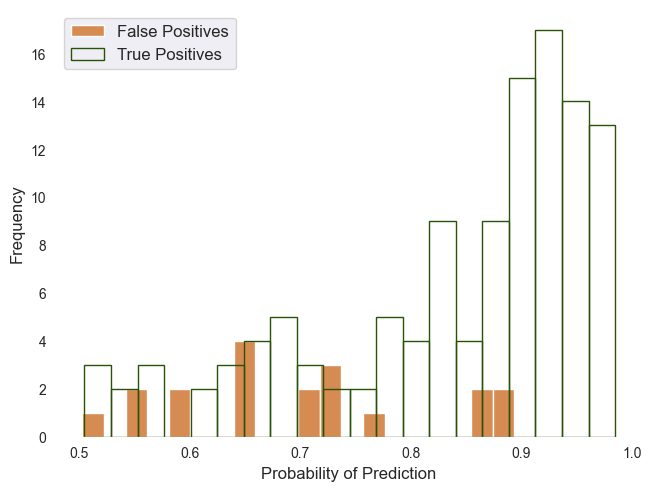

In [63]:
#load optimized model and assess the probabilities
import pickle
model=pickle.load(open('./Updated_Modeling/originalRF_[n_estim,max_depth,max_leaf]_[32, 32, 64].pkl','rb'))
xs=pickle.load(open('./Updated_Modeling_Rev/original_only_landscapes_test_emd_list.pkl','rb'))
ys=pickle.load(open('./Updated_Modeling_Rev/original_testys_np_list.pkl','rb'))
x=xs[0][0]
y=ys[0]
x_ter=xs[0][1]
y_ter=ys[1]
#get the predicted classes and probabilities of each class prediction for the test set
orig_class=model.predict(x)
ter_class=model.predict(x_ter)
orig_prob=model.predict_proba(x)
ter_prob=model.predict_proba(x_ter)

print(orig_class, orig_prob)
print(ter_class,ter_prob)

import matplotlib.pyplot as plt
#build lists of false pos, false neg, true pos, true neg, list value is prob of predicted class
ters=[[],[],[],[]]
for i in range(len(ter_class)):
    if y_ter[i]-ter_class[i]==-1:
        ters[0]+=[ter_prob[i][1]]
    elif y_ter[i]-ter_class[i]==1:
        ters[1]+=[ter_prob[i][0]]
    elif ter_class[i]==1 and y_ter[i]-ter_class[i]==0:
        ters[2]+=[ter_prob[i][1]]
    elif ter_class[i]==0 and y_ter[i]-ter_class[i]==0:
        ters[3]+=[ter_prob[i][0]]
print(ters)

origs=[[],[],[],[]]
for i in range(len(orig_class)):
    if y[i]-orig_class[i]==-1:
        origs[0]+=[orig_prob[i][1]]
    elif y[i]-orig_class[i]==1:
        origs[1]+=[orig_prob[i][0]]
    elif orig_class[i]==1 and y[i]-orig_class[i]==0:
        origs[2]+=[orig_prob[i][1]]
    elif orig_class[i]==0 and y[i]-orig_class[i]==0:
        origs[3]+=[orig_prob[i][0]]

print(origs)

plt.rcParams["font.family"] = "Arial"
fig,ax=plt.subplots(layout='constrained')
counts,bins=np.histogram(origs[0]+ters[0],bins=20)
xs=[]
for i in range(len(bins)-1):
    xs+=[(bins[i]+bins[i+1])/2]
print(counts,bins)
ax.bar(xs,counts,width=bins[1]-bins[0],color='#d58b52',label='False Positives')

print(xs)
#ax.hist(origs[1],bins=20,alpha=0.8)
counts,bins=np.histogram(origs[2]+ters[2],bins=20)
print(counts,bins)
xs=[]
for i in range(len(bins)-1):
    xs+=[(bins[i]+bins[i+1])/2]
print(xs)
ax.bar(xs,counts,width=bins[1]-bins[0],facecolor='none',edgecolor='#295208',label='True Positives')
ax.set_xlabel('Probability of Prediction',fontsize=12)
ax.set_ylabel('Frequency',fontsize=12)
ax.legend(fontsize=12)
ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.savefig('./prediction_dist_bar_rev'+'.pdf',dpi=300)

plt.show()

In [51]:
#train and evaluate models with increasing amounts of terpolymer data
C_rf=[16,16,128]
C_sdg=['log_loss',0.01]
#train and evaluate with the different amounts of data from the training sets
original_data_eval_binary=[] #list of lists - each 'row' or list is a different amount of library data, each value in the row is different amount of terpolymer data
original_data_eval_ter=[]
original_data_eval_combo=[]
for i in range(len(original_only_training_sets)-1,len(original_only_training_sets)):
    print('i',i)
    sublist_binary=[]
    sublist_ter=[]
    sublist_combo=[]
    for j in range(len(terog_sets)):
        print("j",j)
        print(i,np.shape(original_only_training_sets[i]),j,np.shape(terog_sets[j]))
        xset=np.concatenate(original_only_training_sets[:i+1]+terog_sets[:j+1],axis=0)
        ys=np.concatenate(y_original_only_sets[:i+1]+y_terog_sets[:j+1],axis=0)
        # print(np.shape(original_only_training_sets[i]),np.shape(terog_sets[j]))
        trained=train_rf(C_rf,xset,ys,'original_terincr_og_sets_'+str(i)+'_ter_sets_'+str(j))
        eval=[]
        for k in range(len(Xs_orig)):
            eval+=[trained.score(Xs_orig[k],Ys_orig[k])]
        sublist_binary+=[eval[0]]
        sublist_ter+=[eval[1]]
        sublist_combo+=[eval[2]]
    original_data_eval_binary+=[sublist_binary]
    original_data_eval_ter+=[sublist_ter]
    original_data_eval_combo+=[sublist_combo]
numpy_binary=np.array(original_data_eval_binary)
numpy_ter=np.array(original_data_eval_ter)
numpy_combo=np.array(original_data_eval_combo)
print(numpy_binary)
np.save('./Updated_Modeling_Rev/og_rf16-16-128_binarytest_increasingter',numpy_binary[0],allow_pickle=False)
np.save('./Updated_Modeling_Rev/og_rf16-16-128_tertest_increasingter',numpy_ter[0],allow_pickle=False)
np.save('./Updated_Modeling_Rev/og_rf16-16-128_combotest_increasingter',numpy_combo[0],allow_pickle=False)



i 4
j 0
4 (110, 109) 0 (48, 109)
X (594, 109)
Y (594,)
j 1
4 (110, 109) 1 (49, 109)
X (643, 109)
Y (643,)
j 2
4 (110, 109) 2 (50, 109)
X (693, 109)
Y (693,)
j 3
4 (110, 109) 3 (55, 109)
X (748, 109)
Y (748,)
j 4
4 (110, 109) 4 (61, 109)
X (809, 109)
Y (809,)
[[0.74545455 0.75454545 0.77272727 0.72727273 0.76363636]]


In [61]:
#train and evaluate with the different amounts of data from the training sets
original_data_eval_binary=[] #list of lists - each 'row' or list is a different amount of library data, each value in the row is different amount of terpolymer data
original_data_eval_ter=[]
original_data_eval_combo=[]
for i in range(len(original_only_training_sets)-1,len(original_only_training_sets)):
    print('i',i)
    sublist_binary=[]
    sublist_ter=[]
    sublist_combo=[]
    for j in range(len(terog_sets)):
        print("j",j)
        print(i,np.shape(original_only_training_sets[i]),j,np.shape(terog_sets[j]))
        xset=np.concatenate(original_only_training_sets[:i+1]+terog_sets[:j+1],axis=0)
        ys=np.concatenate(y_original_only_sets[:i+1]+y_terog_sets[:j+1],axis=0)
        print(xset,ys)
        # print(np.shape(original_only_training_sets[i]),np.shape(terog_sets[j]))
        trained=train_lin(C_sdg,xset,ys,'original_terincr_og_sets_'+str(i)+'_ter_sets_'+str(j))
        eval=[]
        for k in range(len(Xs_orig)):
            eval+=[trained.score(Xs_orig[k],Ys_orig[k])]
        sublist_binary+=[eval[0]]
        sublist_ter+=[eval[1]]
        sublist_combo+=[eval[2]]
    original_data_eval_binary+=[sublist_binary]
    original_data_eval_ter+=[sublist_ter]
    original_data_eval_combo+=[sublist_combo]
numpy_binary=np.array(original_data_eval_binary)
numpy_ter=np.array(original_data_eval_ter)
numpy_combo=np.array(original_data_eval_combo)
print(numpy_binary)
np.save('./Updated_Modeling_Rev/og_sdg-log-0.01_binarytest_increasingter',numpy_binary[0],allow_pickle=False)
np.save('./Updated_Modeling_Rev/og_sdg-log-0.01_tertest_increasingter',numpy_ter[0],allow_pickle=False)
np.save('./Updated_Modeling_Rev/og_sdg-log-0.01_combotest_increasingter',numpy_combo[0],allow_pickle=False)



i 4
j 0
4 (110, 109) 0 (48, 109)
[[0.         0.46992481 0.85436017 ... 0.63709836 0.72687067 0.82361111]
 [0.46992481 0.         0.67779517 ... 0.76453406 0.75238203 0.92159091]
 [0.85436017 0.67779517 0.         ... 0.7686612  0.78937788 0.80378151]
 ...
 [0.58110233 0.93991603 0.85872022 ... 0.71882706 0.836876   0.70369915]
 [0.58468656 0.94350026 0.8556433  ... 0.72730268 0.84535162 0.80975976]
 [0.58110233 0.93991603 0.85872022 ... 0.71882706 0.836876   0.70369915]] [0 0 1 1 1 1 0 0 0 1 1 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 1 0 1 0 0 1
 1 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0
 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0 1 0 1 1 1 1 0 0 0 0 0
 0 0 1 1 1 1 1 1 0 1 0 0 0 0 1 0 1 1 1 0 1 0 1 0 0 1 1 0 0 0 0 1 0 1 1 1 0
 0 0 1 0 0 0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0
 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 0 0 0 1 0 0 1 1 1 1 1 0 0 1 0 0 0 0 0 1 1 1
 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 

In [65]:
#feature analysis
#load optimized model and assess the features
import pickle
model=pickle.load(open('./Updated_Modeling/originalRF_[n_estim,max_depth,max_leaf]_[32, 32, 64].pkl','rb'))
xs=pickle.load(open('./Updated_Modeling_Rev/original_only_landscapes_test_emd_list.pkl','rb'))
ys=pickle.load(open('./Updated_Modeling_Rev/original_testys_np_list.pkl','rb'))
feature_identities=pd.read_csv('./ML_splits/original_split0.csv',header=0)
x=xs[0][0]
y=ys[0]
x_ter=xs[0][1]
y_ter=ys[1]

feature_importance_df=pd.DataFrame({'SMILES':feature_identities['SMILES_List'],'importance':model.feature_importances_})
feature_importance_df.to_csv('./Updated_Modeling_Rev/feature_analysis.csv')

In [77]:
#build function which runs all desired train test combinations (6) for getting model error.
def rf_eval(C, xs, ys,name):
    #C should be [n_estimators, max_depth,max_leaf_nnodes]
    #xs and ys give a list of the different dataset splices - must be same length, indices in each must match
        #this should be the full training set (will iterate which set is being used as the validation set for cross validation
    #added in option for testx and test y to be list of tests rather than just one test
    scores_orig = []
    scores_test=[]
    scores_combo=[]
    scores=[scores_orig,scores_test,scores_combo]
    for i in range(0, len(xs)):
        X = concatenate_indices(xs, i)
        Y = concatenate_indices(ys, i)
        model = RandomForestClassifier(n_estimators=C[0], max_depth=C[1], min_samples_split=2, min_samples_leaf=1,max_leaf_nodes=C[2],random_state=42)
        model.fit(X[0], Y[0])
        # split up test sets into original, ter, combined
        splits=[109,109,109,109,110,110]
        X_test=[X[1][0:splits[i],:],X[1][splits[1]:len(X[1]),:],X[1]]
        Y_test=[Y[1][0:splits[i]],Y[1][splits[1]:len(X[1])],Y[1]]
        for j in range(3):
            scores[j] += [model.score(X_test[j], Y_test[j])]
    score_array = np.array(scores)
    mean = np.mean(score_array,axis=1)
    std = np.std(score_array,axis=1)

    np.save('./Updated_Modeling_Rev/Landscape_eval_'+name+'_mean[orig,ter,combo]-std[orig,ter,combo]',np.array([mean,std]),allow_pickle=False)
    return [mean, std]

In [67]:
# we have the indices of the different splits when original and terpolymer data are combined, but we don't have the splits within those between original and terpolymer which we need to get separate test sets for the error evaluation. To get those, we need to evaluate the number original library members in each split, which we can get from the length of the os_trains
for i in range(len(os_train)):
    print(len(os_train[i]))

109
109
109
109
110
110


In [78]:
# redo the landscape study, but calculate all 5 possible test/train splits, get average and standard devs
#first build all the different split set ups
#we made 5 different landscapes for only original or original plus ter
#start with original only
#retraining max performance RF models with different landscape ranges and evaluating them
original_rf_max=[16,16,128]
#reduced_rf_max=[64,256,8]

with open('./Updated_Modeling_Rev/Landscape_study_w-error.csv','w',newline='') as file:
        file_writer=csv.writer(file, delimiter=',')
        file_writer.writerow(['Landscape Category','Landscape Number','RF Parameters [max trees, max depth, max leaf nodes]','Binary Polymers Score','Terpolymer Test Score','Combined Test Score', 'Original Std','Ter std','Combined Std'])
#original only
for i in range(len(original_only_emd_train)):
    #first open a file to record all the data
    C=original_rf_max
   #original only basis
    original_only_train_emd_0=original_only_emd_train[i][0:157,:]
    Y_orig_train_0=Y_orig_train[0:157]
    original_only_train_emd_1=original_only_emd_train[i][157:315,:]
    Y_orig_train_1=Y_orig_train[157:315]
    original_only_train_emd_2=original_only_emd_train[i][315:474,:]
    Y_orig_train_2=Y_orig_train[315:474]
    original_only_train_emd_3=original_only_emd_train[i][474:638,:]
    Y_orig_train_3=Y_orig_train[474:638]
    original_only_train_emd_4=original_only_emd_train[i][638:809,:]
    Y_orig_train_4=Y_orig_train[638:809]
    #combine into lists and add what we originally designated as the test sets
    x_values=[original_only_train_emd_0,original_only_train_emd_1,original_only_train_emd_2,original_only_train_emd_3,original_only_train_emd_4,original_only_emd_test[i][2]]
    y_values=[Y_orig_train_0,Y_orig_train_1,Y_orig_train_2,Y_orig_train_3,Y_orig_train_4,original_test_ylist[2]]
#run the modeling
    model=rf_eval(C,x_values,y_values,'orig_only_test_'+str(i))
    #get the scores and errors for the testing parameters of interest
    orig_score=model[0][0]
    ter_score=model[0][1]
    combined_score=model[0][2]
    with open('./Updated_Modeling_Rev/Landscape_study_w-error.csv','a',newline='') as file:
        file_writer=csv.writer(file, delimiter=',')
        file_writer.writerow(['Original Only',i,str(C),orig_score,ter_score,combined_score,model[1][0],model[1][1],model[1][2]])
#original with terpolymers
for i in range(len(original_ter_emd_train)):
    #first open a file to record all the data
    C=original_rf_max
    #train the model with the data and specific landscape
    #original only basis
    original_ter_train_emd_0=original_ter_emd_train[i][0:157,:]
    Y_orig_train_0=Y_orig_train[0:157]
    original_ter_train_emd_1=original_ter_emd_train[i][157:315,:]
    Y_orig_train_1=Y_orig_train[157:315]
    original_ter_train_emd_2=original_ter_emd_train[i][315:474,:]
    Y_orig_train_2=Y_orig_train[315:474]
    original_ter_train_emd_3=original_ter_emd_train[i][474:638,:]
    Y_orig_train_3=Y_orig_train[474:638]
    original_ter_train_emd_4=original_ter_emd_train[i][638:809,:]
    Y_orig_train_4=Y_orig_train[638:809]
    #combine into lists and add what we originally designated as the test sets
    x_values=[original_ter_train_emd_0,original_ter_train_emd_1,original_ter_train_emd_2,original_ter_train_emd_3,original_ter_train_emd_4,original_ter_emd_test[i][2]]
    y_values=[Y_orig_train_0,Y_orig_train_1,Y_orig_train_2,Y_orig_train_3,Y_orig_train_4,original_test_ylist[2]]
#run the modeling
    model=rf_eval(C,x_values,y_values,'orig_ter_test'+str(i))
    #get the scores and errors for the testing parameters of interest
    orig_score=model[0][0]
    ter_score=model[0][1]
    combined_score=model[0][2]

    with open('./Updated_Modeling_Rev/Landscape_study_w-error.csv','a',newline='') as file:
        file_writer=csv.writer(file, delimiter=',')
        file_writer.writerow(['Original and Ter',i,str(C),orig_score,ter_score,combined_score,model[1][0],model[1][1],model[1][2]])

In [142]:
#build function which runs all desired train test combinations (6) for getting model error with increasing amounts of terpolymer data
def rf_eval_incr(C, xs_o, ys_o,xs_t,ys_t,name):
    #C should be [n_estimators, max_depth,max_leaf_nnodes]
    #xs and ys give a list of the different dataset splices - must be same length, indices in each must match
        #this should be the full training set (will iterate which set is being used as the validation set for cross validation
    #O is the number of original library sets to include, T is the number of terpolymer sets, should always be included sets +1 since we will iteratively drop one of the selected sets
    #added in option for testx and test y to be list of tests rather than just one test
    scores_orig = []
    scores_test=[]
    scores_combo=[]
    scores=[scores_orig,scores_test,scores_combo]
    for i in range(0, len(xs_o)):
        if len(xs_o)<=2:
            if i==0:
                X_O=xs_o
                Y_O=ys_o
            if i==1:
                X_O=[xs_o[1],xs_o[0]]
                Y_O=[ys_o[1],ys_o[0]]
        else:
            X_O = concatenate_indices(xs_o, i)
            Y_O = concatenate_indices(ys_o, i)
        if len(xs_t)==1:
            model = RandomForestClassifier(n_estimators=C[0], max_depth=C[1], min_samples_split=2, min_samples_leaf=1,max_leaf_nodes=C[2],random_state=42)
            model.fit(X_O[0], Y_O[0])
            # split up test sets into original, ter, combined
            splits=[109,109,109,109,110,110]
            X_test=[X_O[1],xs_t[0],np.concatenate([X_O[1],xs_t[0]],0)]
            Y_test=[Y_O[1],ys_t[0],np.concatenate([Y_O[1],ys_t[0]])]
            for j in range(3):
                scores[j] += [model.score(X_test[j], Y_test[j])]
        else:
            for k in range(0,len(xs_t)):
                X_T=concatenate_indices(xs_t,k)
                Y_T=concatenate_indices(ys_t,k)
                X_train=np.concatenate([X_O[0],X_T[0]],0)
                print(Y_O[0],Y_T[0])
                Y_train=np.concatenate([Y_O[0],Y_T[0]])

                model = RandomForestClassifier(n_estimators=C[0], max_depth=C[1], min_samples_split=2, min_samples_leaf=1,max_leaf_nodes=C[2],random_state=42)
                model.fit(X_train, Y_train)
            # split up test sets into original, ter, combined
                splits=[109,109,109,109,110,110]
                X_test=[X_O[1],X_T[1],np.concatenate([X_O[1],X_T[1]],0)]
                Y_test=[Y_O[1],Y_T[1],np.concatenate([Y_O[1],Y_T[1]])]
                for j in range(3):
                    scores[j] += [model.score(X_test[j], Y_test[j])]
    score_array = np.array(scores)
    mean = np.mean(score_array,axis=1)
    std = np.std(score_array,axis=1)

    np.save('./Updated_Modeling_Rev/increasinng_ter_eval_'+name+'_mean[orig,ter,combo]-std[orig,ter,combo]',np.array([mean,std]),allow_pickle=False)
    return [mean, std]

In [106]:
#take the optimized models with the minimum representations to study how different amounts of training data impact the accuracy - include what has previously been termed the "test" data to get estimations of error

#need to construct the matrix of training data
#we need list of the emd matrixes for each original set vs original, reduced set vs reduced and terpolymer sets vs each. plus corresponding ys
orig_optim_C=[32,32,64]
reduced_optim_C=[64,8,32]
#[0, 25, 23, 25, 24, 25, 25, 28, 27, 30, 31]
#split up training data for cross val optimization
#original only basis
i=0
original_only_train_emd_0=original_only_emd_train[i][0:157,:]
Y_orig_train_0=Y_orig_train[0:157]
original_only_train_emd_1=original_only_emd_train[i][157:315,:]
Y_orig_train_1=Y_orig_train[157:315]
original_only_train_emd_2=original_only_emd_train[i][315:474,:]
Y_orig_train_2=Y_orig_train[315:474]
original_only_train_emd_3=original_only_emd_train[i][474:638,:]
Y_orig_train_3=Y_orig_train[474:638]
original_only_train_emd_4=original_only_emd_train[i][638:809,:]
Y_orig_train_4=Y_orig_train[638:809]

original_only_training_sets=[original_only_train_emd_0[:-48],original_only_train_emd_1[:-49],original_only_train_emd_2[:-50],original_only_train_emd_3[:-55],original_only_train_emd_4[:-61],original_only_emd_test[0][0]]
y_original_only_sets=[Y_orig_train_0[:-48],Y_orig_train_1[:-49],Y_orig_train_2[:-50],Y_orig_train_3[:-55],Y_orig_train_4[:-61],original_test_ylist[0]]

terog_sets=[original_only_train_emd_0[-48:],original_only_train_emd_1[-49:],original_only_train_emd_2[-50:],original_only_train_emd_3[-55:],original_only_train_emd_4[-61:],original_only_emd_test[0][1]]
y_terog_sets=[Y_orig_train_0[-48:],Y_orig_train_1[-49:],Y_orig_train_2[-50:],Y_orig_train_3[-55:],Y_orig_train_4[-61:],original_test_ylist[1]]



In [101]:
def get_index(interest, list):
    #interest is list of elements you want to match
    #list is the list you want to find the elements in
    #returns a list of indeces
    ind=[]
    for i in range(len(interest)):
        for j in range(len(list)):
            #print(type(interest[i]))
            if np.array_equal(interest[i],list[j]):
                ind+=[j]
    return ind

In [129]:
#train and evaluate models with increasing amounts of terpolymer data
C_rf=[16,16,128]
C_sdg=['log_loss',0.01]
import random
#train and evaluate with the different amounts of data from the training sets
original_data_eval_binary_mean=[] #list of lists - each 'row' or list is a different amount of library data, each value in the row is different amount of terpolymer data
original_data_eval_ter_mean=[]
original_data_eval_combo_mean=[]
original_data_eval_binary_std=[] #list of lists - each 'row' or list is a different amount of library data, each value in the row is different amount of terpolymer data
original_data_eval_ter_std=[]
original_data_eval_combo_std=[]

for i in range(len(original_only_training_sets)-1,len(original_only_training_sets)):
    #always use all the original library data, so i should always be 5
    print('i',i)
    sublist_binary_mean=[]
    sublist_ter_mean=[]
    sublist_combo_mean=[]
    sublist_binary_std=[]
    sublist_ter_std=[]
    sublist_combo_std=[]
    for j in range(len(terog_sets)):
        #run 0 to 6 here so that the first data points have no terpolymer data
        print("j",j)
        print(i,np.shape(original_only_training_sets[i]),j,np.shape(terog_sets[j]))
        xset_o=original_only_training_sets[:i+1]
        xset_t=random.sample(terog_sets,j+1)
        t_ind=get_index(xset_t,terog_sets)
        ys_o=y_original_only_sets[:i+1]
        ys_t=[y_terog_sets[m] for m in t_ind]
        # print(np.shape(original_only_training_sets[i]),np.shape(terog_sets[j]))
        trained=rf_eval_incr(C_rf,xset_o,ys_o,xset_t,ys_t,'orig_set_'+str(i)+'ter_set_'+str(j))
        sublist_binary_mean+=[trained[0][0]]
        sublist_ter_mean+=[trained[0][1]]
        sublist_combo_mean+=[trained[0][2]]
        sublist_binary_std+=[trained[1][0]]
        sublist_ter_std+=[trained[1][1]]
        sublist_combo_std+=[trained[1][2]]
    original_data_eval_binary_mean+=[sublist_binary_mean]
    original_data_eval_ter_mean+=[sublist_ter_mean]
    original_data_eval_combo_mean+=[sublist_combo_mean]
    original_data_eval_binary_std+=[sublist_binary_std]
    original_data_eval_ter_std+=[sublist_ter_std]
    original_data_eval_combo_std+=[sublist_combo_std]
numpy_binary_mean=np.array(original_data_eval_binary_mean[0])
numpy_ter_mean=np.array(original_data_eval_ter_mean[0])
numpy_combo_mean=np.array(original_data_eval_combo_mean[0])
print(numpy_binary_mean)
numpy_binary_std=np.array(original_data_eval_binary_std[0])
numpy_ter_std=np.array(original_data_eval_ter_std[0])
numpy_combo_std=np.array(original_data_eval_combo_std[0])
np.save('./Updated_Modeling_Rev/og_rf16-16-128_binarytest_increasingter-means',numpy_binary_mean,allow_pickle=False)
np.save('./Updated_Modeling_Rev/og_rf16-16-128_tertest_increasingter-means',numpy_ter_mean,allow_pickle=False)
np.save('./Updated_Modeling_Rev/og_rf16-16-128_combotest_increasingter-means',numpy_combo_mean,allow_pickle=False)
np.save('./Updated_Modeling_Rev/og_rf16-16-128_binarytest_increasingter-std',numpy_binary_std,allow_pickle=False)
np.save('./Updated_Modeling_Rev/og_rf16-16-128_tertest_increasingter-std',numpy_ter_std,allow_pickle=False)
np.save('./Updated_Modeling_Rev/og_rf16-16-128_combotest_increasingter-std',numpy_combo_std,allow_pickle=False)

i 5
j 0
5 (110, 109) 0 (48, 109)
j 1
5 (110, 109) 1 (49, 109)
j 2
5 (110, 109) 2 (50, 109)
j 3
5 (110, 109) 3 (55, 109)
j 4
5 (110, 109) 4 (61, 109)
j 5
5 (110, 109) 5 (81, 109)
[0.71342786 0.71414373 0.71749143 0.72179594 0.72253823 0.72558845]


In [125]:
#build function which runs all desired train test combinations (6) for getting model error with increasing amounts of terpolymer data
def sgd_eval_incr(C, xs_o, ys_o,xs_t,ys_t,name):
    #C should be [loss, alpha]
    #xs and ys give a list of the different dataset splices - must be same length, indices in each must match
        #this should be the full training set (will iterate which set is being used as the validation set for cross validation
    #O is the number of original library sets to include, T is the number of terpolymer sets, should always be included sets +1 since we will iteratively drop one of the selected sets
    #added in option for testx and test y to be list of tests rather than just one test
    scores_orig = []
    scores_test=[]
    scores_combo=[]
    scores=[scores_orig,scores_test,scores_combo]
    for i in range(0, len(xs_o)):
        X_O = concatenate_indices(xs_o, i)
        Y_O = concatenate_indices(ys_o, i)
        if len(xs_t)==1:
            model = SGDClassifier(loss=C[0], alpha=C[1], shuffle=True,random_state=42)
            model.fit(X_O[0], Y_O[0])
            # split up test sets into original, ter, combined
            splits=[109,109,109,109,110,110]
            X_test=[X_O[1],xs_t[0],np.concatenate([X_O[1],xs_t[0]],0)]
            Y_test=[Y_O[1],ys_t[0],np.concatenate([Y_O[1],ys_t[0]])]
            for j in range(3):
                scores[j] += [model.score(X_test[j], Y_test[j])]
        else:
            for k in range(0,len(xs_t)):
                X_T=concatenate_indices(xs_t,k)
                Y_T=concatenate_indices(ys_t,k)
                X_train=np.concatenate([X_O[0],X_T[0]],0)
                #print(Y_O[0],Y_T[0])
                Y_train=np.concatenate([Y_O[0],Y_T[0]])

                model = SGDClassifier(loss=C[0], alpha=C[1], shuffle=True,random_state=42)
                model.fit(X_train, Y_train)
            # split up test sets into original, ter, combined
                splits=[109,109,109,109,110,110]
                X_test=[X_O[1],X_T[1],np.concatenate([X_O[1],X_T[1]],0)]
                Y_test=[Y_O[1],Y_T[1],np.concatenate([Y_O[1],Y_T[1]])]
                for j in range(3):
                    scores[j] += [model.score(X_test[j], Y_test[j])]
    score_array = np.array(scores)
    mean = np.mean(score_array,axis=1)
    std = np.std(score_array,axis=1)

    np.save('./Updated_Modeling_Rev/increasinng_ter_eval_sdg_'+name+'_mean[orig,ter,combo]-std[orig,ter,combo]',np.array([mean,std]),allow_pickle=False)
    return [mean, std]

In [130]:
#train and evaluate models with increasing amounts of terpolymer data
C_rf=[16,16,128]
C_sgd=['log_loss',0.01]
import random
#train and evaluate with the different amounts of data from the training sets
original_data_eval_binary_mean=[] #list of lists - each 'row' or list is a different amount of library data, each value in the row is different amount of terpolymer data
original_data_eval_ter_mean=[]
original_data_eval_combo_mean=[]
original_data_eval_binary_std=[] #list of lists - each 'row' or list is a different amount of library data, each value in the row is different amount of terpolymer data
original_data_eval_ter_std=[]
original_data_eval_combo_std=[]

for i in range(len(original_only_training_sets)-1,len(original_only_training_sets)):
    #always use all the original library data, so i should always be 5
    print('i',i)
    sublist_binary_mean=[]
    sublist_ter_mean=[]
    sublist_combo_mean=[]
    sublist_binary_std=[]
    sublist_ter_std=[]
    sublist_combo_std=[]
    for j in range(len(terog_sets)):
        #run 0 to 6 here so that the first data points have no terpolymer data
        print("j",j)
        print(i,np.shape(original_only_training_sets[i]),j,np.shape(terog_sets[j]))
        xset_o=original_only_training_sets[:i+1]
        xset_t=random.sample(terog_sets,j+1)
        t_ind=get_index(xset_t,terog_sets)
        ys_o=y_original_only_sets[:i+1]
        ys_t=[y_terog_sets[m] for m in t_ind]
        # print(np.shape(original_only_training_sets[i]),np.shape(terog_sets[j]))
        trained=sgd_eval_incr(C_sgd,xset_o,ys_o,xset_t,ys_t,'orig_set_'+str(i)+'ter_set_'+str(j))
        sublist_binary_mean+=[trained[0][0]]
        sublist_ter_mean+=[trained[0][1]]
        sublist_combo_mean+=[trained[0][2]]
        sublist_binary_std+=[trained[1][0]]
        sublist_ter_std+=[trained[1][1]]
        sublist_combo_std+=[trained[1][2]]
    original_data_eval_binary_mean+=[sublist_binary_mean]
    original_data_eval_ter_mean+=[sublist_ter_mean]
    original_data_eval_combo_mean+=[sublist_combo_mean]
    original_data_eval_binary_std+=[sublist_binary_std]
    original_data_eval_ter_std+=[sublist_ter_std]
    original_data_eval_combo_std+=[sublist_combo_std]
numpy_binary_mean=np.array(original_data_eval_binary_mean[0])
numpy_ter_mean=np.array(original_data_eval_ter_mean[0])
numpy_combo_mean=np.array(original_data_eval_combo_mean[0])
print(numpy_binary_mean)
numpy_binary_std=np.array(original_data_eval_binary_std[0])
numpy_ter_std=np.array(original_data_eval_ter_std[0])
numpy_combo_std=np.array(original_data_eval_combo_std[0])
np.save('./Updated_Modeling_Rev/og_sgd_logloss_0.01_binarytest_increasingter-means',numpy_binary_mean,allow_pickle=False)
np.save('./Updated_Modeling_Rev/og_sgd_logloss_0.01_tertest_increasingter-means',numpy_ter_mean,allow_pickle=False)
np.save('./Updated_Modeling_Rev/og_sgd_logloss_0.01_combotest_increasingter-means',numpy_combo_mean,allow_pickle=False)
np.save('./Updated_Modeling_Rev/og_sgd_logloss_0.01_binarytest_increasingter-std',numpy_binary_std,allow_pickle=False)
np.save('./Updated_Modeling_Rev/og_sgd_logloss_0.01_tertest_increasingter-std',numpy_ter_std,allow_pickle=False)
np.save('./Updated_Modeling_Rev/og_sgd_logloss_0.01_combotest_increasingter-std',numpy_combo_std,allow_pickle=False)

i 5
j 0
5 (110, 109) 0 (48, 109)
j 1
5 (110, 109) 1 (49, 109)
j 2
5 (110, 109) 2 (50, 109)
j 3
5 (110, 109) 3 (55, 109)
j 4
5 (110, 109) 4 (61, 109)
j 5
5 (110, 109) 5 (81, 109)
[0.67378371 0.65543508 0.67125846 0.62734918 0.6134084  0.59373552]


In [143]:
#get the full matrix of training data impact for og and ter increases using the optimized models from all the data
#train and evaluate models with increasing amounts of terpolymer data
C_rf_optim=[32,32,64]
import random
#train and evaluate with the different amounts of data from the training sets
original_data_eval_binary_mean=[] #list of lists - each 'row' or list is a different amount of library data, each value in the row is different amount of terpolymer data
original_data_eval_ter_mean=[]
original_data_eval_combo_mean=[]
original_data_eval_binary_std=[] #list of lists - each 'row' or list is a different amount of library data, each value in the row is different amount of terpolymer data
original_data_eval_ter_std=[]
original_data_eval_combo_std=[]

for i in range(1,len(original_only_training_sets)):
    #we want to have at least one set of original library data (plus the one we pull for cross val)
    print('i',i)
    sublist_binary_mean=[]
    sublist_ter_mean=[]
    sublist_combo_mean=[]
    sublist_binary_std=[]
    sublist_ter_std=[]
    sublist_combo_std=[]
    for j in range(1,len(terog_sets)):
        #run 1 to 6 here so we always have at least one terpolymer set + test set)
        print("j",j)
        print(i,np.shape(original_only_training_sets[i]),j,np.shape(terog_sets[j]))
        xset_o=random.sample(original_only_training_sets,i+1)
        #print(xset_o)
        xset_t=random.sample(terog_sets,j+1)
        o_ind=get_index(xset_o,original_only_training_sets)
        t_ind=get_index(xset_t,terog_sets)
        ys_o=[y_original_only_sets[l] for l in o_ind]
        ys_t=[y_terog_sets[m] for m in t_ind]
        # print(np.shape(original_only_training_sets[i]),np.shape(terog_sets[j]))
        trained=rf_eval_incr(C_rf_optim,xset_o,ys_o,xset_t,ys_t,'full_matrix_orig_set_'+str(i)+'ter_set_'+str(j))
        sublist_binary_mean+=[trained[0][0]]
        sublist_ter_mean+=[trained[0][1]]
        sublist_combo_mean+=[trained[0][2]]
        sublist_binary_std+=[trained[1][0]]
        sublist_ter_std+=[trained[1][1]]
        sublist_combo_std+=[trained[1][2]]
    original_data_eval_binary_mean+=[sublist_binary_mean]
    original_data_eval_ter_mean+=[sublist_ter_mean]
    original_data_eval_combo_mean+=[sublist_combo_mean]
    original_data_eval_binary_std+=[sublist_binary_std]
    original_data_eval_ter_std+=[sublist_ter_std]
    original_data_eval_combo_std+=[sublist_combo_std]
numpy_binary_mean=np.array(original_data_eval_binary_mean)
numpy_ter_mean=np.array(original_data_eval_ter_mean)
numpy_combo_mean=np.array(original_data_eval_combo_mean)
print(numpy_binary_mean)
numpy_binary_std=np.array(original_data_eval_binary_std)
numpy_ter_std=np.array(original_data_eval_ter_std)
numpy_combo_std=np.array(original_data_eval_combo_std)
np.save('./Updated_Modeling_Rev/incr_data_rf-32-32-64_binarytest-means',numpy_binary_mean,allow_pickle=False)
np.save('./Updated_Modeling_Rev/incr_data_rf-32-32-64_tertest-means',numpy_ter_mean,allow_pickle=False)
np.save('./Updated_Modeling_Rev/incr_data_rf-32-32-64_combotest-means',numpy_combo_mean,allow_pickle=False)
np.save('./Updated_Modeling_Rev/incr_data_rf-32-32-64_binarytest-std',numpy_binary_std,allow_pickle=False)
np.save('./Updated_Modeling_Rev/incr_data_rf-32-32-64_tertest-std',numpy_ter_std,allow_pickle=False)
np.save('./Updated_Modeling_Rev/incr_data_rf-32-32-64_combotest-std',numpy_combo_std,allow_pickle=False)

i 1
j 1
1 (109, 109) 1 (49, 109)
[0 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 0 1 0
 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 1 0 0 1 0 1] [1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1]
[0 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 0 1 0
 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 1 0 0 1 0 1] [1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 1 1 1 1 1 1 0 1 0 0 0 0 1 0 1 1 1 0 1 0 1 0 0 1 1 0 0 0 0 1 0 1 1
 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 0 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 0 0 0 1 0 0 1 1 1 1 1 0 0 1 0 0 0 0] [1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1